# EDI-FEATURES


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops

In [2]:
ds_path = r"dataset/images"
diseases= os.listdir(ds_path)

In [3]:
diseases

['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']

In [4]:
from skimage import exposure
from skimage.feature import hog
from skimage.measure import regionprops
from scipy import stats
from skimage.measure import label

# Set the dataset path
ds_path = r"dataset/images"

def features():
    names = ['area', 'perimeter', 'physiological_length', 'physiological_width', 'aspect_ratio',
             'mean_r', 'mean_g', 'mean_b', 'stddev_r', 'stddev_g', 'stddev_b',
             'contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity',
             'eccentricity', 'solidity', 'equiv_diameter', 'major_axis_length', 'minor_axis_length',
             'skewness', 'kurtosis', 'hog_feature_1', 'hog_feature_2', 'hog_feature_3', 'types'
            ]
    df = pd.DataFrame(columns=names)

    # Count the number of subfolders in the dataset path to determine the number of classes (labels)
    class_folders = [f for f in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, f))]
    num_classes = len(class_folders)

    print("Number of Classes: ", num_classes)
    print("Classes: ", class_folders)

    types = 0

    for folder in class_folders:
        disease_folder = os.path.join(ds_path, folder)

        types = folder

        for image in os.listdir(disease_folder):
            imgpath = os.path.join(disease_folder, image)
            main_img = cv2.imread(imgpath)

            # Preprocessing
            img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
            gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            blur = cv2.GaussianBlur(gs, (25, 25), 0)
            ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            kernel = np.ones((50, 50), np.uint8)
            closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

            # Shape features
            contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cnt = contours[0]
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h

            # Color features
            red_channel = img[:, :, 0]
            green_channel = img[:, :, 1]
            blue_channel = img[:, :, 2]

            red_mean = np.mean(red_channel)
            green_mean = np.mean(green_channel)
            blue_mean = np.mean(blue_channel)

            # Std deviation
            red_std = np.std(red_channel)
            green_std = np.std(green_channel)
            blue_std = np.std(blue_channel)

            # Texture features using GLCM matrix
            glcm = graycomatrix(gs,
                                distances=[1],
                                angles=[0],
                                symmetric=True,
                                normed=True)

            properties = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity']
            contrast = graycoprops(glcm, properties[0])
            energy = graycoprops(glcm, properties[1])
            homogeneity = graycoprops(glcm, properties[2])
            correlation = graycoprops(glcm, properties[3])
            dissimilarity = graycoprops(glcm, properties[4])

            # Statistical moments
            skewness = stats.skew(gs.flatten())
            kurtosis = stats.kurtosis(gs.flatten())

            # Additional features
            labeled_img = label(closing)
            regions = regionprops(labeled_img)

            eccentricity = regions[0].eccentricity
            solidity = regions[0].solidity
            equiv_diameter = regions[0].equivalent_diameter
            major_axis_length = regions[0].major_axis_length
            minor_axis_length = regions[0].minor_axis_length

            # HOG features
            hog_features = hog(gs, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys')

            vector = [area, perimeter, w, h, aspect_ratio,
                      red_mean, green_mean, blue_mean, red_std, green_std, blue_std,
                      contrast[0][0], energy[0][0], homogeneity[0][0], correlation[0][0], dissimilarity[0][0],
                      eccentricity, solidity, equiv_diameter, major_axis_length, minor_axis_length,
                      skewness, kurtosis, hog_features[0], hog_features[1], hog_features[2], types]

            df_temp = pd.DataFrame([vector], columns=names)
            df = pd.concat([df, df_temp], ignore_index=True)
    return df

In [5]:
# Call the function to create the feature dataframe
feature_df = features()

# Save the resulting dataframe to a CSV file
feature_df.to_csv("dataset/csv/image_features.csv", index=False)

Number of Classes:  4
Classes:  ['Cercospora Leaf Spot', 'Common Rust', 'Healthy', 'Northern Leaf Blight']


In [6]:
feature_df.head()

,area,perimeter,physiological_length,physiological_width,aspect_ratio,mean_r,mean_g,mean_b,stddev_r,stddev_g,...,solidity,equiv_diameter,major_axis_length,minor_axis_length,skewness,kurtosis,hog_feature_1,hog_feature_2,hog_feature_3,types
0,26541.0,775.396968,133,256,0.519531,104.563095,107.743637,68.655884,55.589260,57.343041,...,0.672820,94.393487,305.439785,40.313109,0.059651,-1.187179,0.243761,0.486964,0.486964,Cercospora Leaf Spot
1,55969.0,1004.225396,256,256,1.000000,116.466217,118.686493,98.196548,29.424495,25.288295,...,0.819053,248.781378,320.956273,265.874886,0.178179,-0.323515,0.445656,0.066757,0.362304,Cercospora Leaf Spot
2,42062.0,1262.308656,256,256,1.000000,99.803757,115.969910,84.885330,34.389686,24.195702,...,0.732934,233.107952,307.312129,238.270818,0.718827,0.400085,0.394570,0.448935,0.448935,Cercospora Leaf Spot
3,3169.0,404.710677,44,175,0.251429,119.812561,134.660645,89.565430,34.034694,27.977782,...,0.900000,3.385138,6.052283,1.695890,-0.298695,3.081536,0.474238,0.000000,0.243578,Cercospora Leaf Spot
4,43446.5,1475.438598,256,256,1.000000,91.394882,100.050995,76.148911,73.317851,71.876494,...,0.695025,237.155667,324.332242,276.174194,0.480650,-1.181136,0.413076,0.413076,0.413076,Cercospora Leaf Spot


# PCA

## Components

In [7]:
import pandas as pd
from sklearn.decomposition import PCA

In [8]:
df = pd.read_csv("dataset/csv/image_features.csv")

In [9]:
# Assuming df is your DataFrame with the features
X = df.drop('types', axis=1)
pca = PCA()
X_pca = pca.fit_transform(X)

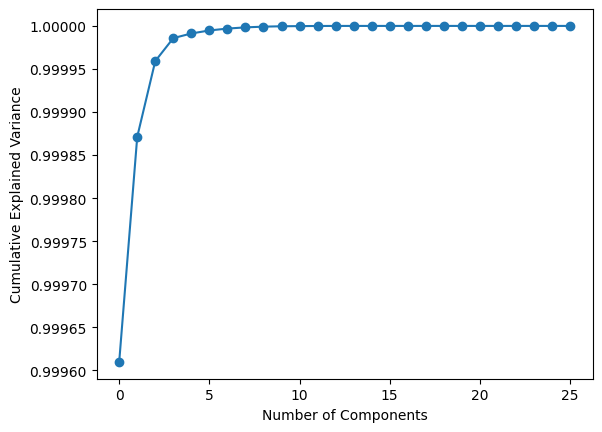

In [10]:
import matplotlib.pyplot as plt

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Training

In [11]:
import pandas as pd

In [12]:
data=pd.read_csv("dataset/csv/image_features.csv")

In [13]:
types = data["types"]

In [14]:
types_labels = types.unique()
types_labels

array(['Cercospora Leaf Spot', 'Common Rust', 'Healthy',
       'Northern Leaf Blight'], dtype=object)

In [15]:
data = data.drop('types', axis=1)

In [16]:
data.head()

,area,perimeter,physiological_length,physiological_width,aspect_ratio,mean_r,mean_g,mean_b,stddev_r,stddev_g,...,eccentricity,solidity,equiv_diameter,major_axis_length,minor_axis_length,skewness,kurtosis,hog_feature_1,hog_feature_2,hog_feature_3
0,26541.0,775.396968,133,256,0.519531,104.563095,107.743637,68.655884,55.589260,57.343041,...,0.991252,0.672820,94.393487,305.439785,40.313109,0.059651,-1.187179,0.243761,0.486964,0.486964
1,55969.0,1004.225396,256,256,1.000000,116.466217,118.686493,98.196548,29.424495,25.288295,...,0.560161,0.819053,248.781378,320.956273,265.874886,0.178179,-0.323515,0.445656,0.066757,0.362304
2,42062.0,1262.308656,256,256,1.000000,99.803757,115.969910,84.885330,34.389686,24.195702,...,0.631546,0.732934,233.107952,307.312129,238.270818,0.718827,0.400085,0.394570,0.448935,0.448935
3,3169.0,404.710677,44,175,0.251429,119.812561,134.660645,89.565430,34.034694,27.977782,...,0.959940,0.900000,3.385138,6.052283,1.695890,-0.298695,3.081536,0.474238,0.000000,0.243578
4,43446.5,1475.438598,256,256,1.000000,91.394882,100.050995,76.148911,73.317851,71.876494,...,0.524328,0.695025,237.155667,324.332242,276.174194,0.480650,-1.181136,0.413076,0.413076,0.413076


In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 14)
pca.fit(data)

PCA(n_components=14)

In [18]:
# Access the loadings of the first three principal components
loadings = pca.components_[:14]

# Map the loadings to the original feature names
original_feature_names = data.columns
component_loadings = pd.DataFrame(loadings, columns=original_feature_names)

# Display the loadings for the first three components
print(component_loadings)

        area  perimeter  physiological_length  physiological_width  \
0   0.999894   0.013336              0.003422             0.002840   
1  -0.013366   0.957473              0.124180             0.122517   
2   0.004302  -0.196397             -0.037370             0.000352   
3   0.001439   0.060573              0.093774             0.097472   
4  -0.001101   0.093091              0.138955            -0.574364   
5  -0.000748  -0.004982             -0.089696             0.425803   
6   0.000196  -0.082532              0.777154            -0.313509   
7   0.002796   0.019466             -0.342906            -0.210250   
8   0.001744   0.154066             -0.469814            -0.543706   
9   0.000329   0.032901             -0.050425            -0.152836   
10 -0.000175  -0.010827              0.040930             0.048501   
11 -0.000087  -0.002793              0.015815             0.016305   
12  0.000009   0.000115              0.014257            -0.010258   
13 -0.000027  -0.001

In [19]:
data2=pca.transform(data)

In [20]:
data2

array([[-5.78067231e+03, -1.31423455e+01,  2.72025492e+02, ...,
        -5.98409116e+00,  5.65522209e-01, -6.51566818e-01],
       [ 2.36489445e+04, -2.04861882e+02,  1.33158474e+02, ...,
        -6.53075576e+00, -1.96274116e+00, -2.28955840e+00],
       [ 9.74679612e+03,  2.19209708e+02, -1.28679371e+01, ...,
         1.10292940e+00,  2.82916339e+00,  4.99299776e+00],
       ...,
       [ 2.01281156e+03,  2.59488632e+02, -8.08785176e+01, ...,
         6.10289159e+00, -2.22798857e+00,  3.76503881e+00],
       [ 2.54205057e+02,  2.71113995e+02,  1.80075651e+02, ...,
        -1.12630630e+01, -4.51653240e+00,  1.57905768e+00],
       [ 2.24594449e+04, -1.47036900e+02, -7.43904652e+01, ...,
        -9.86875879e+00, -1.79680499e+00,  5.81618244e+00]])

In [21]:
data2=pd.DataFrame(data2)
data2 = data2.join(types)

In [22]:
data2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,-5780.672314,-13.142346,272.025492,105.825635,-113.063397,64.915855,20.762981,47.668148,43.550094,-3.503807,7.887935,-5.984091,0.565522,-0.651567,Cercospora Leaf Spot
1,23648.944499,-204.861882,133.158474,-30.494389,-14.265260,-8.751050,13.368092,6.179064,-8.966217,-19.277451,-5.670979,-6.530756,-1.962741,-2.289558,Cercospora Leaf Spot
2,9746.796117,219.209708,-12.867937,-3.293447,6.374704,-10.654790,-5.312235,-26.286550,19.029868,-16.971616,1.966728,1.102929,2.829163,4.992998,Cercospora Leaf Spot
3,-29155.560082,-181.872037,-143.065563,302.274141,1.866438,-13.337681,-97.736312,0.700180,-18.819478,-39.502359,7.728957,-10.606927,-1.932096,2.771004,Cercospora Leaf Spot
4,11133.719505,457.005089,180.182559,-25.157945,23.250130,-36.946879,-25.047603,3.090292,21.546443,38.397648,-5.507482,4.051033,-1.194426,0.161795,Cercospora Leaf Spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,18851.153844,-231.838797,-5.959636,-11.466747,-31.043979,-2.749741,-13.450295,-8.135372,-0.943466,4.360224,-14.519823,-11.373166,-2.451640,-3.502217,Northern Leaf Blight
3848,6606.968859,-100.902698,35.748877,9.092631,-36.056016,26.743810,6.186012,-25.400698,-4.001032,-5.323297,-5.692337,-1.003286,-4.957514,4.128230,Northern Leaf Blight
3849,2012.811561,259.488632,-80.878518,5.265154,8.272016,14.033275,-22.119904,-20.814841,15.156007,-19.335006,3.712943,6.102892,-2.227989,3.765039,Northern Leaf Blight
3850,254.205057,271.113995,180.075651,4.869551,16.228890,57.839833,31.944437,-15.533220,-11.503982,24.473710,3.121097,-11.263063,-4.516532,1.579058,Northern Leaf Blight


In [23]:
data2.index=data.index

In [24]:
data2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,-5780.672314,-13.142346,272.025492,105.825635,-113.063397,64.915855,20.762981,47.668148,43.550094,-3.503807,7.887935,-5.984091,0.565522,-0.651567,Cercospora Leaf Spot
1,23648.944499,-204.861882,133.158474,-30.494389,-14.265260,-8.751050,13.368092,6.179064,-8.966217,-19.277451,-5.670979,-6.530756,-1.962741,-2.289558,Cercospora Leaf Spot
2,9746.796117,219.209708,-12.867937,-3.293447,6.374704,-10.654790,-5.312235,-26.286550,19.029868,-16.971616,1.966728,1.102929,2.829163,4.992998,Cercospora Leaf Spot
3,-29155.560082,-181.872037,-143.065563,302.274141,1.866438,-13.337681,-97.736312,0.700180,-18.819478,-39.502359,7.728957,-10.606927,-1.932096,2.771004,Cercospora Leaf Spot
4,11133.719505,457.005089,180.182559,-25.157945,23.250130,-36.946879,-25.047603,3.090292,21.546443,38.397648,-5.507482,4.051033,-1.194426,0.161795,Cercospora Leaf Spot


In [25]:
print(pca.explained_variance_ratio_)

[9.99609889e-01 2.61351055e-04 8.79554887e-05 2.66466457e-05
 5.39068655e-06 3.50104841e-06 2.17210710e-06 1.41611286e-06
 8.17858442e-07 4.62333160e-07 1.74498402e-07 1.64434995e-07
 3.97097280e-08 1.24699944e-08]


In [26]:
data2.shape

(3852, 15)

In [27]:
data2.to_csv("dataset/csv/pca.csv", index=False)

In [28]:
import joblib
# Save the PCA model to a file
joblib.dump(pca, 'models/pca/Corn_pca_model.pkl')

['models/pca/Corn_pca_model.pkl']

# SVM

In [29]:
import pandas as pd

In [30]:
data = pd.read_csv("dataset/csv/pca.csv")

In [31]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,-5780.672314,-13.142346,272.025492,105.825635,-113.063397,64.915855,20.762981,47.668148,43.550094,-3.503807,7.887935,-5.984091,0.565522,-0.651567,Cercospora Leaf Spot
1,23648.944499,-204.861882,133.158474,-30.494389,-14.265260,-8.751050,13.368092,6.179064,-8.966217,-19.277451,-5.670979,-6.530756,-1.962741,-2.289558,Cercospora Leaf Spot
2,9746.796117,219.209708,-12.867937,-3.293447,6.374704,-10.654790,-5.312235,-26.286550,19.029868,-16.971616,1.966728,1.102929,2.829163,4.992998,Cercospora Leaf Spot
3,-29155.560082,-181.872037,-143.065563,302.274141,1.866438,-13.337681,-97.736312,0.700180,-18.819478,-39.502359,7.728957,-10.606927,-1.932096,2.771004,Cercospora Leaf Spot
4,11133.719505,457.005089,180.182559,-25.157945,23.250130,-36.946879,-25.047603,3.090292,21.546443,38.397648,-5.507482,4.051033,-1.194426,0.161795,Cercospora Leaf Spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,18851.153844,-231.838797,-5.959636,-11.466747,-31.043979,-2.749741,-13.450295,-8.135372,-0.943466,4.360224,-14.519823,-11.373166,-2.451640,-3.502217,Northern Leaf Blight
3848,6606.968859,-100.902698,35.748877,9.092631,-36.056016,26.743810,6.186012,-25.400698,-4.001032,-5.323297,-5.692337,-1.003286,-4.957514,4.128230,Northern Leaf Blight
3849,2012.811561,259.488632,-80.878518,5.265154,8.272016,14.033275,-22.119904,-20.814841,15.156007,-19.335006,3.712943,6.102892,-2.227989,3.765039,Northern Leaf Blight
3850,254.205057,271.113995,180.075651,4.869551,16.228890,57.839833,31.944437,-15.533220,-11.503982,24.473710,3.121097,-11.263063,-4.516532,1.579058,Northern Leaf Blight


### Sampling

In [32]:
# Extract the features (X) and labels (y)
X = data.iloc[:, :-1]  # Select all columns except the last one as features
y = data['types']  # Select the 'types' column as the target variable

# Check the shape of X and y to ensure they are correct
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3852, 14)
y shape: (3852,)


Class distribution before SMOTE:
types
Common Rust             1192
Healthy                 1162
Northern Leaf Blight     985
Cercospora Leaf Spot     513
Name: count, dtype: int64


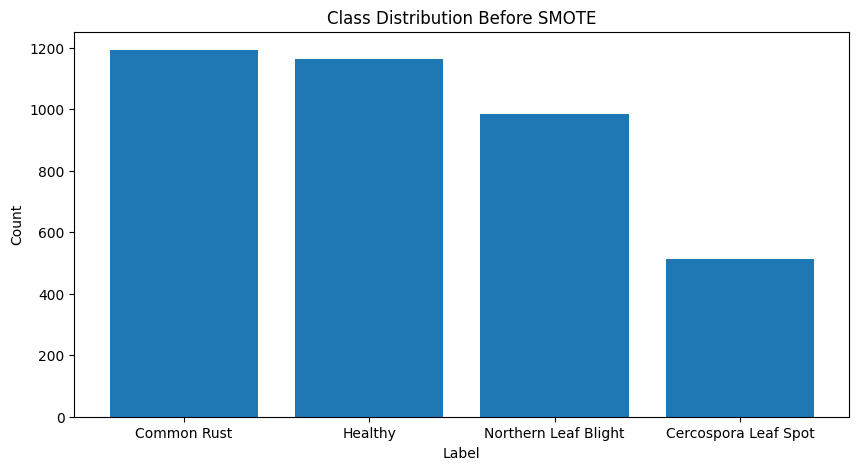

Class distribution after SMOTE:
Counter({'Cercospora Leaf Spot': 1192, 'Common Rust': 1192, 'Healthy': 1192, 'Northern Leaf Blight': 1192})


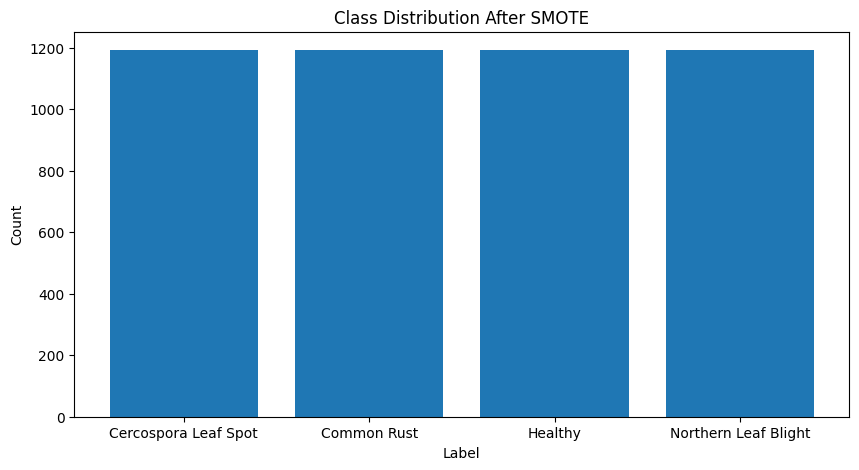

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

# Extract the features (X) and labels (y)
X = data.iloc[:, :-1]  # Select all columns except the last one as features
y = data['types']  # Select the 'types' column as the target variable

# Check the class distribution before applying SMOTE
label_counts_before = y.value_counts()
print("Class distribution before SMOTE:")
print(label_counts_before)

# Create a bar chart to visualize the class distribution before SMOTE
plt.figure(figsize=(10, 5))
plt.bar(label_counts_before.index, label_counts_before.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution Before SMOTE')
plt.show()

# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution after applying SMOTE
label_counts_after = Counter(y_resampled)
print("Class distribution after SMOTE:")
print(label_counts_after)

# Create a bar chart to visualize the class distribution after SMOTE
plt.figure(figsize=(10, 5))
plt.bar(label_counts_after.keys(), label_counts_after.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution After SMOTE')
plt.show()

In [34]:
# Overwrite DataFrame with the resampled data
data = pd.DataFrame(X_resampled, columns=X.columns)
data['types'] = y_resampled

### Splitting

In [35]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,types
0,-5780.672314,-13.142346,272.025492,105.825635,-113.063397,64.915855,20.762981,47.668148,43.550094,-3.503807,7.887935,-5.984091,0.565522,-0.651567,Cercospora Leaf Spot
1,23648.944499,-204.861882,133.158474,-30.494389,-14.265260,-8.751050,13.368092,6.179064,-8.966217,-19.277451,-5.670979,-6.530756,-1.962741,-2.289558,Cercospora Leaf Spot
2,9746.796117,219.209708,-12.867937,-3.293447,6.374704,-10.654790,-5.312235,-26.286550,19.029868,-16.971616,1.966728,1.102929,2.829163,4.992998,Cercospora Leaf Spot
3,-29155.560082,-181.872037,-143.065563,302.274141,1.866438,-13.337681,-97.736312,0.700180,-18.819478,-39.502359,7.728957,-10.606927,-1.932096,2.771004,Cercospora Leaf Spot
4,11133.719505,457.005089,180.182559,-25.157945,23.250130,-36.946879,-25.047603,3.090292,21.546443,38.397648,-5.507482,4.051033,-1.194426,0.161795,Cercospora Leaf Spot


In [36]:
x=data.iloc[:,0:14].values

In [37]:
x

array([[-5.78067231e+03, -1.31423455e+01,  2.72025492e+02, ...,
        -5.98409116e+00,  5.65522209e-01, -6.51566818e-01],
       [ 2.36489445e+04, -2.04861882e+02,  1.33158474e+02, ...,
        -6.53075576e+00, -1.96274116e+00, -2.28955840e+00],
       [ 9.74679612e+03,  2.19209708e+02, -1.28679371e+01, ...,
         1.10292940e+00,  2.82916339e+00,  4.99299776e+00],
       ...,
       [ 8.89637211e+03, -2.23605852e+02, -9.50462573e+01, ...,
        -4.23062391e+00, -8.78078920e+00,  4.53812382e+00],
       [ 3.89467980e+03,  4.46230675e+01, -7.27745019e+01, ...,
        -8.21619530e+00, -4.50213606e+00,  1.65027980e+00],
       [ 1.21463513e+04, -9.00125239e+01,  1.45014257e+02, ...,
        -1.38569693e+01, -6.21712490e+00,  3.45901928e-01]])

In [38]:
x.shape

(4768, 14)

In [39]:
y=data.iloc[:,14].values

In [40]:
y

array(['Cercospora Leaf Spot', 'Cercospora Leaf Spot',
       'Cercospora Leaf Spot', ..., 'Northern Leaf Blight',
       'Northern Leaf Blight', 'Northern Leaf Blight'], dtype=object)

In [41]:
from sklearn.preprocessing import StandardScaler
data2=StandardScaler()
x=data2.fit_transform(x)

In [42]:
import joblib

# Save the trained model to a file
joblib.dump(data2, 'models/scalers/Corn_scaler_model.pkl')

['models/scalers/Corn_scaler_model.pkl']

In [43]:
x

array([[-0.35794722, -0.0151261 ,  1.20346397, ..., -0.63694492,
         0.18805463, -0.26827325],
       [ 1.04651908, -0.59991872,  0.53447494, ..., -0.70285199,
        -0.43391622, -0.99114064],
       [ 0.38306842,  0.69360587, -0.16900431, ...,  0.2174817 ,
         0.74492654,  2.2227479 ],
       ...,
       [ 0.34248373, -0.65709252, -0.56489669, ..., -0.42554309,
        -2.11120476,  2.022006  ],
       [ 0.10378853,  0.16107288, -0.45760297, ..., -0.90605225,
        -1.05862551,  0.74756217],
       [ 0.49758212, -0.2495994 ,  0.59158994, ..., -1.58611623,
        -1.48052502,  0.17192293]])

In [44]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

### Default Parameters Training

In [45]:
from sklearn.svm import SVC

# Assuming x_train is your feature matrix and y_train is your target variable as a NumPy array
svm = SVC()

# Train the SVM model
strain = svm.fit(x_train, y_train)

In [46]:
strain

SVC()

In [47]:
import joblib

# Save the trained model to a file
joblib.dump(strain, 'models/classifiers/Corn_classifier_model.pkl')

['models/classifiers/Corn_classifier_model.pkl']

### Testing

In [48]:
x_test

array([[-1.37148162,  0.12141026,  2.37189667, ...,  0.38684231,
         0.66817749, -0.39884607],
       [-1.50746591, -0.74092575,  1.15227975, ...,  0.08266792,
         0.80051861, -0.21532906],
       [ 0.82933224, -0.56663412, -0.0634645 , ..., -1.53100271,
        -1.8630641 , -0.35471177],
       ...,
       [ 0.700744  , -0.23000956,  0.36019375, ..., -0.59498241,
        -0.99936987,  0.10230635],
       [-1.50888995,  0.18539461,  0.62699103, ...,  0.23363404,
         0.57583458,  0.08631174],
       [ 0.83971299, -0.416505  , -0.78967342, ...,  0.26517377,
         0.95276424,  0.72017632]])

In [49]:
y_pred=strain.predict(x_test)

In [50]:
y_pred

array(['Common Rust', 'Common Rust', 'Northern Leaf Blight',
       'Northern Leaf Blight', 'Cercospora Leaf Spot', 'Common Rust',
       'Healthy', 'Northern Leaf Blight', 'Cercospora Leaf Spot',
       'Cercospora Leaf Spot', 'Healthy', 'Common Rust', 'Common Rust',
       'Common Rust', 'Common Rust', 'Cercospora Leaf Spot',
       'Cercospora Leaf Spot', 'Common Rust', 'Northern Leaf Blight',
       'Northern Leaf Blight', 'Healthy', 'Common Rust',
       'Northern Leaf Blight', 'Common Rust', 'Common Rust',
       'Common Rust', 'Cercospora Leaf Spot', 'Northern Leaf Blight',
       'Healthy', 'Common Rust', 'Healthy', 'Northern Leaf Blight',
       'Cercospora Leaf Spot', 'Cercospora Leaf Spot',
       'Cercospora Leaf Spot', 'Healthy', 'Healthy',
       'Cercospora Leaf Spot', 'Cercospora Leaf Spot',
       'Northern Leaf Blight', 'Northern Leaf Blight', 'Healthy',
       'Healthy', 'Northern Leaf Blight', 'Cercospora Leaf Spot',
       'Cercospora Leaf Spot', 'Northern Leaf Bli

In [51]:
y_test

array(['Common Rust', 'Common Rust', 'Northern Leaf Blight',
       'Northern Leaf Blight', 'Cercospora Leaf Spot', 'Common Rust',
       'Healthy', 'Northern Leaf Blight', 'Northern Leaf Blight',
       'Northern Leaf Blight', 'Healthy', 'Common Rust', 'Common Rust',
       'Common Rust', 'Common Rust', 'Northern Leaf Blight',
       'Cercospora Leaf Spot', 'Common Rust', 'Cercospora Leaf Spot',
       'Northern Leaf Blight', 'Healthy', 'Common Rust',
       'Northern Leaf Blight', 'Common Rust', 'Common Rust',
       'Common Rust', 'Cercospora Leaf Spot', 'Northern Leaf Blight',
       'Healthy', 'Common Rust', 'Healthy', 'Northern Leaf Blight',
       'Cercospora Leaf Spot', 'Northern Leaf Blight',
       'Cercospora Leaf Spot', 'Healthy', 'Healthy',
       'Cercospora Leaf Spot', 'Northern Leaf Blight',
       'Northern Leaf Blight', 'Northern Leaf Blight', 'Healthy',
       'Healthy', 'Northern Leaf Blight', 'Cercospora Leaf Spot',
       'Cercospora Leaf Spot', 'Northern Leaf Bli

In [52]:
print("Number of Training Data:", len(y_train))
print("Number of Testing Data:", len(y_test))

Number of Training Data: 3814
Number of Testing Data: 954


In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[181,   2,   0,  57],
       [  1, 244,   1,   0],
       [  1,   0, 240,   0],
       [ 42,   2,   1, 182]], dtype=int64)

In [54]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8878406708595388

### Testing Models

In [75]:
main_img = cv2.imread('dataset/images/Cercospora Leaf Spot/00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp 4655.jpg')

names = ['area', 'perimeter', 'physiological_length', 'physiological_width', 'aspect_ratio',
             'mean_r', 'mean_g', 'mean_b', 'stddev_r', 'stddev_g', 'stddev_b',
             'contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity',
             'eccentricity', 'solidity', 'equiv_diameter', 'major_axis_length', 'minor_axis_length',
             'skewness', 'kurtosis', 'hog_feature_1', 'hog_feature_2', 'hog_feature_3'
            ]
df = pd.DataFrame(columns=names)

# Preprocessing
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gs, (25, 25), 0)
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((50, 50), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Shape features
contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt, True)
x, y, w, h = cv2.boundingRect(cnt)
aspect_ratio = float(w) / h

# Color features
red_channel = img[:, :, 0]
green_channel = img[:, :, 1]
blue_channel = img[:, :, 2]

red_mean = np.mean(red_channel)
green_mean = np.mean(green_channel)
blue_mean = np.mean(blue_channel)

# Std deviation
red_std = np.std(red_channel)
green_std = np.std(green_channel)
blue_std = np.std(blue_channel)

# Texture features using GLCM matrix
glcm = graycomatrix(gs,
                distances=[1],
                angles=[0],
                symmetric=True,
                normed=True)

properties = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity']
contrast = graycoprops(glcm, properties[0])
energy = graycoprops(glcm, properties[1])
homogeneity = graycoprops(glcm, properties[2])
correlation = graycoprops(glcm, properties[3])
dissimilarity = graycoprops(glcm, properties[4])

# Statistical moments
skewness = stats.skew(gs.flatten())
kurtosis = stats.kurtosis(gs.flatten())

# Additional features
labeled_img = label(closing)
regions = regionprops(labeled_img)

eccentricity = regions[0].eccentricity
solidity = regions[0].solidity
equiv_diameter = regions[0].equivalent_diameter
major_axis_length = regions[0].major_axis_length
minor_axis_length = regions[0].minor_axis_length

# HOG features
hog_features = hog(gs, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys')

vector = [area, perimeter, w, h, aspect_ratio,
        red_mean, green_mean, blue_mean, red_std, green_std, blue_std,
        contrast[0][0], energy[0][0], homogeneity[0][0], correlation[0][0], dissimilarity[0][0],
        eccentricity, solidity, equiv_diameter, major_axis_length, minor_axis_length,
        skewness, kurtosis, hog_features[0], hog_features[1], hog_features[2]]

df_temp = pd.DataFrame([vector], columns=names)
df = pd.concat([df, df_temp], ignore_index=True)

pca_model = joblib.load('models/pca/Corn_pca_model.pkl')
pca = pca_model.transform(df)

scaler_model = joblib.load('models/scalers/Corn_scaler_model.pkl')
scaled = scaler_model.transform(pca)

classifier_model = joblib.load('models/classifiers/Corn_classifier_model.pkl')
results = classifier_model.predict(scaled)

print('FEATURES', df)
print('PCA', pca)
print('SCALED', scaled)
print('RESULTS', results)

FEATURES       area    perimeter physiological_length physiological_width  \
0  55969.0  1004.225396                  256                 256   

   aspect_ratio      mean_r      mean_g     mean_b   stddev_r   stddev_g  ...  \
0           1.0  116.466217  118.686493  98.196548  29.424495  25.288295  ...   

   eccentricity  solidity  equiv_diameter  major_axis_length  \
0      0.560161  0.819053      248.781378         320.956273   

   minor_axis_length  skewness  kurtosis  hog_feature_1  hog_feature_2  \
0         265.874886  0.178179 -0.323515       0.445656       0.066757   

   hog_feature_3  
0       0.362304  

[1 rows x 26 columns]
PCA [[ 2.36489445e+04 -2.04861882e+02  1.33158474e+02 -3.04943885e+01
  -1.42652601e+01 -8.75105037e+00  1.33680917e+01  6.17906372e+00
  -8.96621698e+00 -1.92774509e+01 -5.67097939e+00 -6.53075576e+00
  -1.96274116e+00 -2.28955840e+00]]
SCALED [[ 1.04651908 -0.59991872  0.53447494 -0.26868599 -0.32429683 -0.24423328
   0.4466665   0.35345903 -0.5130

### Checking

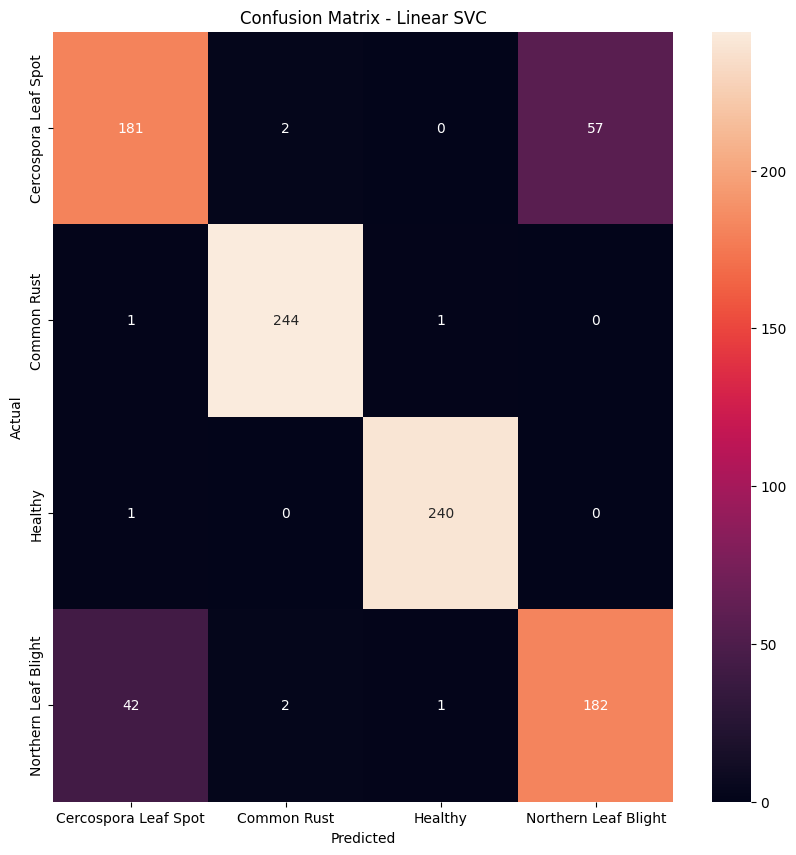

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the true labels and 'y_pred' contains the predicted labels
conf_mat = confusion_matrix(y_test, y_pred, labels=data['types'].unique())

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=data['types'].unique(),
            yticklabels=data['types'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Linear SVC")
plt.show()

In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have true labels (y_true) and predicted labels (y_pred)
y_true = y_test
y_pred = y_pred

data=pd.read_csv("dataset/csv/image_features.csv")
types = data["types"]
types_labels = types.unique()

# Compute precision, recall, and F1-score for each class
classes =  types_labels

precision = precision_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, labels=classes, average=None, zero_division=0)

# Display the results for each class
for class_label, p, r, f in zip(classes, precision, recall, f1):
    print(f"Class {class_label} - Precision: {p} \n\t\t  Recall: {r} \n\t\t  F1-Score: {f}\n")

Class Cercospora Leaf Spot - Precision: 0.8044444444444444 
		  Recall: 0.7541666666666667 
		  F1-Score: 0.7784946236559139

Class Common Rust - Precision: 0.9838709677419355 
		  Recall: 0.991869918699187 
		  F1-Score: 0.9878542510121457

Class Healthy - Precision: 0.9917355371900827 
		  Recall: 0.995850622406639 
		  F1-Score: 0.9937888198757764

Class Northern Leaf Blight - Precision: 0.7615062761506276 
		  Recall: 0.801762114537445 
		  F1-Score: 0.7811158798283263



## Grid Search

In [ ]:
import threading
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel types
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10]  # Kernel coefficient (only for 'rbf', 'poly', 'sigmoid')
}

# Create an SVM model
svm = SVC()

# Create a GridSearchCV object with the SVM model and parameter grid
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# Initialize a variable to keep track of the number of combinations
total_combinations = len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma'])
combination_count = 0

# Create an empty list to store the results
results = []

# Lock for thread synchronization
results_lock = threading.Lock()

# Function to train the SVM model with a timeout
def train_svm_with_timeout(C, kernel, gamma, result_flag):
    try:
        svm = SVC(C=C, kernel=kernel, gamma=gamma)
        svm.fit(x_train, y_train)
        y_pred = svm.predict(x_test)  # Predict on the test data
        accuracy = (y_pred == y_test).mean()  # Calculate accuracy
        with results_lock:
            results.append([C, kernel, gamma, accuracy])
        result_flag[0] = True
    except Exception as e:
        result_flag[0] = False

# Fit the grid search to your training data
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
            combination_count += 1
            print(f"Combination {combination_count}/{total_combinations}: C={C}, kernel={kernel}, gamma={gamma}")

            result_flag = [False]

            t = threading.Thread(target=train_svm_with_timeout, args=(C, kernel, gamma, result_flag))
            t.start()
            t.join(timeout=300)  # Adjust the timeout value as needed

            if result_flag[0]:
                print("Accuracy on test data: ", results[-1][-1])
            else:
                print("Training took too long or encountered an error. Skipping to the next combination.")

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=["C", "Kernel", "Gamma", "Accuracy"])

# Save the DataFrame to a CSV file
output_csv = r"dataset/csv/grid_search_results.csv"
result_df.to_csv(output_csv, index=False)

### Grid Search Training

In [ ]:
import pandas as pd
grid_df=pd.read_csv("dataset/csv/grid_search_results.csv")

In [ ]:
len(grid_df)

In [ ]:
grid_df.head()

In [ ]:
# Find the index of the row with the highest accuracy
max_accuracy_index = grid_df['Accuracy'].idxmax()

# Get the row with the highest accuracy
row_with_highest_accuracy = grid_df.loc[max_accuracy_index]

print(row_with_highest_accuracy)

In [ ]:
for column, value in row_with_highest_accuracy.items():
    data_types = type(value)
    print(f"{column}: {data_types}")

In [ ]:
# Find the index of the row with the highest accuracy
max_accuracy_index = grid_df['Accuracy'].idxmax()

# Replace the values in the row with specific values
grid_df.loc[max_accuracy_index] = {'C': 100.0, 'Kernel': 'rbf', 'Gamma': 1, 'Accuracy': 0.68}

# Print the modified row
print(grid_df.loc[max_accuracy_index])

In [ ]:
row_with_highest_accuracy = grid_df.loc[max_accuracy_index]

In [ ]:
from sklearn.svm import SVC

# Specify the parameters
C = float(row_with_highest_accuracy.C)
kernel = row_with_highest_accuracy.Kernel
gamma_value = row_with_highest_accuracy.Gamma

if isinstance(gamma_value, str):
    gamma = gamma_value
elif isinstance(gamma_value, (int,float)):
    gamma = gamma_value
else:
    raise ValueError("Invalid gamma value")

# Create an SVC with the specified parameters
svm = SVC(C=C, kernel=kernel, gamma=gamma)

# Train the model on your training data
train_grid = svm.fit(x_train, y_train)

In [ ]:
train_grid

In [ ]:
import joblib

# Save the trained model to a file
joblib.dump(train_grid, 'models/classifiers/Corn_classifier_model.pkl')

In [ ]:
y_pred=train_grid.predict(x_test)

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

### Grid Search Checking

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the true labels and 'y_pred' contains the predicted labels
conf_mat = confusion_matrix(y_test, y_pred, labels=data['types'].unique())

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=data['types'].unique(),
            yticklabels=data['types'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Linear SVC")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have true labels (y_true) and predicted labels (y_pred)
y_true = y_test
y_pred = y_pred

data=pd.read_csv("dataset/csv/image_features.csv")
types = data["types"]
types_labels = types.unique()

# Compute precision, recall, and F1-score for each class
classes = types_labels

precision = precision_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
f1 = f1_score(y_true, y_pred, labels=classes, average=None, zero_division=0)

# Display the results for each class
for class_label, p, r, f in zip(classes, precision, recall, f1):
    print(f"Class {class_label} - Precision: {p} \n\t\t  Recall: {r} \n\t\t  F1-Score: {f}\n")